In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import json
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.io import mmread

# MaxFuse imports
import maxfuse as mf
from maxfuse import Fusor, Mario
from maxfuse.mario import pipelined_mario

import warnings
warnings.filterwarnings("ignore")

In [15]:
# Load preprocessed data from 1_preprocessing.ipynb
# Run 1_preprocessing.ipynb first to generate these files

import os

# Fix working directory if notebook started from wrong location
# The notebook expects to run from the notebooks/ directory
notebook_dir = os.path.dirname(os.path.abspath('__file__'))
if not os.path.exists('../results/1_preprocessing') and os.path.exists('/home/smith6jt/maxfuse/results/1_preprocessing'):
    os.chdir('/home/smith6jt/maxfuse/notebooks')
    print(f"Changed working directory to: {os.getcwd()}")

results_dir = '../results/1_preprocessing'

if not os.path.exists(results_dir):
    raise FileNotFoundError(
        f"Results directory '{results_dir}' not found. "
        f"Run 1_preprocessing.ipynb first to generate the input files."
    )

# Load processed AnnData objects
protein_adata = sc.read_h5ad(f'{results_dir}/protein_adata.h5ad')
rna_adata = sc.read_h5ad(f'{results_dir}/rna_adata.h5ad')
rna_adata_lognorm = sc.read_h5ad(f'{results_dir}/rna_adata_lognorm.h5ad')

print(f"Loaded from {results_dir}/")
print(f"  Protein data: {protein_adata.shape}")
print(f"  RNA data: {rna_adata.shape}")
print(f"  RNA log-normalized: {rna_adata_lognorm.shape}")

# # Load preprocessing parameters
# with open(f'{results_dir}/preprocessing_params.json', 'r') as f:
#     preprocess_params = json.load(f)
# print(f"\nPreprocessing timestamp: {preprocess_params['timestamp']}")

Loaded from ../results/1_preprocessing/
  Protein data: (15512, 59)
  RNA data: (2574, 13680)
  RNA log-normalized: (2574, 13680)


## Step 3: Build Protein-Gene Correspondence

Map CODEX protein markers to their corresponding gene names in the RNA data.

In [16]:
# Load correspondence table
correspondence = pd.read_csv('../data/protein_gene_conversion.csv', encoding='utf-8-sig')
print(f"Correspondence table: {correspondence.shape[0]} entries")
correspondence.head(10)

Correspondence table: 370 entries


,Protein name,RNA name
0,CD80,CD80
1,CD86,CD86
2,CD274,CD274
3,CD273,PDCD1LG2
4,CD275,ICOSLG
5,CD275-1,ICOSLG
6,CD275-2,ICOSLG
7,CD11b,ITGAM
8,CD11b-1,ITGAM
9,CD11b-2,ITGAM


In [17]:
# Find matching features between CODEX markers and RNA genes
# Define markers to exclude (non-immune, structural, or problematic for CD45+ RNA data)
EXCLUDED_MARKERS = [
    'DAPI',           # Nuclear stain
    'ECAD', 'E-cadherin',  # Epithelial
    'IAPP', 'INS', 'GCG', 'SST',  # Pancreatic endocrine
    # 'Ker8-18', 'Pan-Cytokeratin', 'Keratin 5', 'EpCAM', 'TP63',  # Epithelial
    # 'Collagen IV', 'Vimentin', 'SMA', 'Caveolin',  # Stromal/structural
    # 'CD31', 'Podoplanin',  # Endothelial/lymphatic
    'Beta-actin',     # Housekeeping
    'LAG3',          # Excluded per user
]

rna_protein_correspondence = []
unmatched_proteins = []

for marker in protein_adata.var_names:
    # Skip excluded markers
    if marker in EXCLUDED_MARKERS:
        continue
    
    # Look up in correspondence table
    matches = correspondence[correspondence['Protein name'].str.lower() == marker.lower()]
    
    if len(matches) == 0:
        # Try alternative names
        alt_names = {
            'CD3e': 'CD3',
            'FoxP3': 'FOXP3',
            'HLADR': 'HLA-DR',
            'Lyve1': 'LYVE1',
            'SMActin': 'SMA',
            'CollagenIV': 'collagen IV',
        }
        alt_marker = alt_names.get(marker, marker)
        matches = correspondence[correspondence['Protein name'].str.lower() == alt_marker.lower()]
    
    if len(matches) > 0:
        rna_names_str = matches.iloc[0]['RNA name']
        if 'Ignore' in str(rna_names_str):
            unmatched_proteins.append((marker, 'Ignored'))
            continue
        
        # Try each RNA name option
        found = False
        for rna_name in str(rna_names_str).split('/'):
            if rna_name in rna_adata.var_names:
                rna_protein_correspondence.append([rna_name, marker])
                found = True
                break
        if not found:
            unmatched_proteins.append((marker, rna_names_str))
    else:
        unmatched_proteins.append((marker, 'Not in table'))

rna_protein_correspondence = np.array(rna_protein_correspondence)
print(f"Found {len(rna_protein_correspondence)} protein-gene pairs")
print(f"Excluded {len(EXCLUDED_MARKERS)} non-immune/structural markers")

if unmatched_proteins:
    print(f"\nUnmatched proteins ({len(unmatched_proteins)}):")
    for prot, reason in unmatched_proteins:
        print(f"  {prot}: {reason}")

Found 50 protein-gene pairs
Excluded 9 non-immune/structural markers

Unmatched proteins (1):
  Pan-Cytokeratin: Ignored


In [18]:
# Remove duplicates (same RNA mapping to multiple proteins)
# Keep first occurrence
seen_rna = set()
unique_pairs = []
for rna, prot in rna_protein_correspondence:
    if rna not in seen_rna:
        seen_rna.add(rna)
        unique_pairs.append([rna, prot])
    else:
        print(f"Removing duplicate RNA mapping: {rna} -> {prot}")

rna_protein_correspondence = np.array(unique_pairs)
print(f"\nFinal correspondence: {len(rna_protein_correspondence)} pairs")

print("\nMatched features:")
for rna, prot in rna_protein_correspondence:
    print(f"  {rna:15} <-> {prot}")


Final correspondence: 50 pairs

Matched features:
  LAMP1           <-> CD107a
  CD4             <-> CD4
  PECAM1          <-> CD31
  ACTA2           <-> SMA
  CD68            <-> CD68
  CD44            <-> CD44
  VIM             <-> Vimentin
  CD99            <-> CD99
  IDO1            <-> IDO1
  CEACAM1         <-> CD66
  KRT8            <-> Ker8-18
  ITGAX           <-> CD11c
  CD38            <-> CD38
  HLA-DRA         <-> HLA-DR
  CD34            <-> CD34
  NOS2            <-> iNOS
  LGALS3          <-> M2Gal3
  TUBB3           <-> B3TUBB
  CD8A            <-> CD8
  PCNA            <-> PCNA
  FOXP3           <-> FOXP3
  B3GAT1          <-> CD57
  MKI67           <-> Ki67
  GZMB            <-> Granzyme B
  HLA-A           <-> HLA-A
  MS4A1           <-> CD20
  COL4A1          <-> Collagen IV
  VSIR            <-> VISTA
  PDCD1           <-> PD-1
  TCF7            <-> TCF-1
  TOX             <-> TOX
  CAV1            <-> Caveolin
  ICOS            <-> ICOS
  CD163           <-> CD1

## Step 4: Prepare Arrays for Integration

Extract and normalize:
- **Shared arrays**: Corresponding protein/gene features (used for initial matching)
- **Active arrays**: All features (used for refinement)

In [19]:
shared_rna_genes = rna_protein_correspondence[:, 0]  # RNA gene names
shared_protein_markers = rna_protein_correspondence[:, 1]  # Protein marker names

# Verify all features exist
missing_rna = [g for g in shared_rna_genes if g not in rna_adata.var_names]
missing_prot = [p for p in shared_protein_markers if p not in protein_adata.var_names]

if missing_rna:
    print(f"WARNING: Missing RNA genes: {missing_rna}")
if missing_prot:
    print(f"WARNING: Missing protein markers: {missing_prot}")

# Create shared feature AnnData objects
rna_shared_adata = rna_adata[:, shared_rna_genes].copy()
protein_shared_adata = protein_adata[:, shared_protein_markers].copy()

print(f"Shared feature AnnData objects created:")
print(f"  rna_shared_adata: {rna_shared_adata.shape}")
print(f"  protein_shared_adata: {protein_shared_adata.shape}")
print(f"\nRNA shared features: {list(rna_shared_adata.var_names[:5])}...")
print(f"Protein shared features: {list(protein_shared_adata.var_names[:5])}...")

Shared feature AnnData objects created:
  rna_shared_adata: (2574, 50)
  protein_shared_adata: (15512, 50)

RNA shared features: ['LAMP1', 'CD4', 'PECAM1', 'ACTA2', 'CD68']...
Protein shared features: ['CD107a', 'CD4', 'CD31', 'SMA', 'CD68']...


In [34]:
# Make sure no column is static
mask = (
    (rna_shared_adata.X.toarray().std(axis=0) > 0.0005)
    & (protein_shared_adata.X.std(axis=0) > 0.0005)
)
rna_shared = rna_shared_adata[:, mask].copy()
protein_shared = protein_shared_adata[:, mask].copy()
print([rna_shared.shape,protein_shared.shape])

[(2574, 46), (15512, 46)]


In [21]:
# process all RNA features
sc.pp.normalize_total(rna_adata)
sc.pp.log1p(rna_adata)
sc.pp.highly_variable_genes(rna_adata, n_top_genes=5000)
keep_genes = ['LAMP1', 'CD4', 'CEACAM1', 'CD38', 'PCNA', 'FOXP3', 'B3GAT1', 'MKI67', 'VSIR', 'PDCD1', 'NCAM1', 'TCF7', 'CD3E', 'ENTPD1']
for gene in keep_genes:
    if gene in rna_adata.var_names:
        rna_adata.var.loc[gene, 'highly_variable'] = True
rna_adata = rna_adata[:, rna_adata.var.highly_variable].copy()
sc.pp.scale(rna_adata)

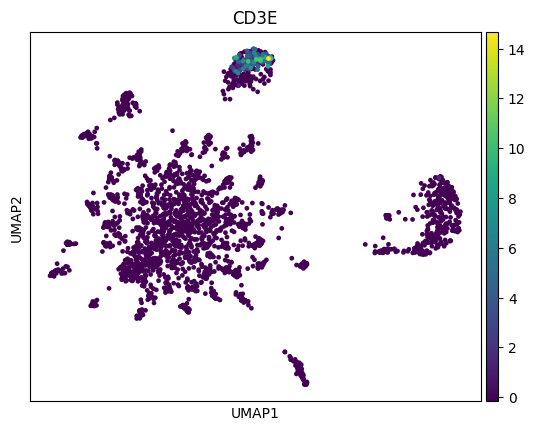

In [22]:
sc.pp.neighbors(rna_adata, n_neighbors=15)
sc.tl.umap(rna_adata, min_dist=0.05, spread=2.5)
sc.pl.umap(rna_adata, color="CD3E")

In [23]:
sc.pp.log1p(protein_adata)
sc.pp.scale(protein_adata)
sc.pp.neighbors(protein_adata, n_neighbors=15)
sc.tl.umap(protein_adata, min_dist=0.05, spread=2.5)

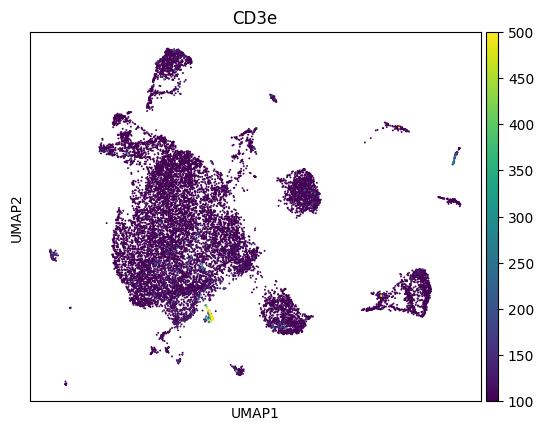

In [27]:
sc.pl.umap(protein_adata, color='CD3e', vmin=100,vmax=500)

In [28]:
# make sure no feature is static
rna_active = rna_adata.X
protein_active = protein_adata.X
rna_active = rna_active[:, rna_active.std(axis=0) > 1e-5] # these are fine since already using variable features
protein_active = protein_active[:, protein_active.std(axis=0) > 1e-5] # protein are generally variable

In [35]:
sc.pp.normalize_total(rna_shared)
sc.pp.log1p(rna_shared)
sc.pp.scale(rna_shared)

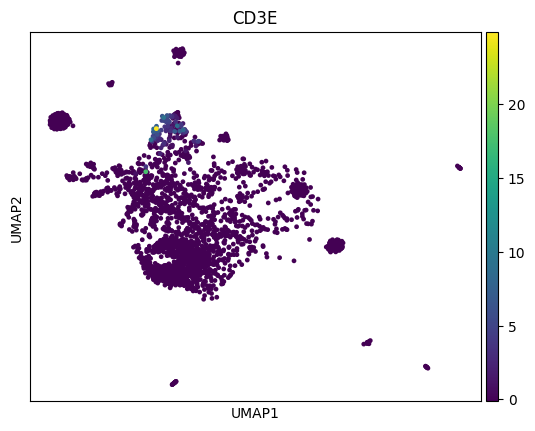

In [37]:
sc.pp.neighbors(rna_shared, n_neighbors=15)
sc.tl.umap(rna_shared, min_dist=0.5, spread=1.5)
sc.pl.umap(rna_shared, color="CD3E")

In [38]:
sc.pp.log1p(protein_shared)
sc.pp.scale(protein_shared)
sc.pp.neighbors(protein_shared, n_neighbors=15)
sc.tl.umap(protein_shared, min_dist=0.05, spread=2.5)

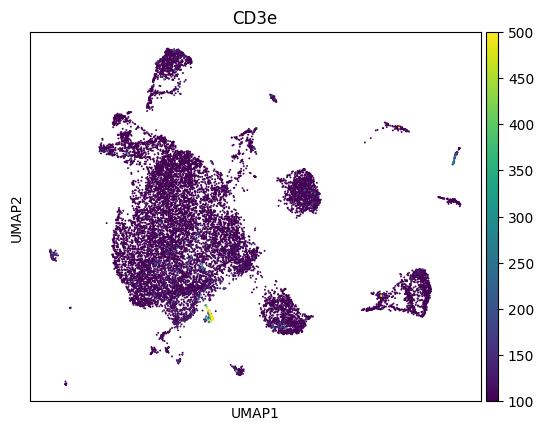

In [39]:
sc.pl.umap(protein_adata, color='CD3e', vmin=100,vmax=500)

In [40]:
# inspect shape of the four matrices
print(rna_active.shape)
print(protein_active.shape)
print(rna_shared.shape)
print(protein_shared.shape)

(2574, 5012)
(15512, 59)
(2574, 46)
(15512, 46)


In [48]:
fusor = Fusor(
    shared_arr1=rna_shared.X,
    shared_arr2=protein_shared.X,
    active_arr1=rna_active,
    active_arr2=protein_active,
    labels1=None,  # Let MaxFuse cluster
    labels2=None
)


In [49]:
# Calculate appropriate batching parameters
n_rna = rna_active.shape[0]
n_prot = protein_active.shape[0]
ratio = n_prot / n_rna

print(f"RNA cells: {n_rna}")
print(f"Protein cells: {n_prot}")
print(f"Ratio (protein/RNA): {ratio:.1f}")

# Batching parameters
max_outward = min(8000, n_rna)

# CRITICAL FIX: For very large protein:RNA ratios, cap the matching ratio
# The algorithm propagates matches via pivot cells, so we don't need every
# protein cell in initial batches. Using sqrt scaling prevents over-sampling
# that leads to excessive filtering and cell loss.
matching_ratio = min(100, max(10, int(ratio) + 5))  # sqrt scaling for large ratios

# Metacell size: with only 19 features, metacells of size 2 provide minimal benefit
# Use size=1 (no metacells) for direct cell matching, or increase to 5+ for noise reduction
metacell_sz = 2  # No metacells - direct matching with small feature panel

print(f"\nBatching parameters:")
print(f"  max_outward_size: {max_outward}")
print(f"  matching_ratio: {matching_ratio} (sqrt-scaled, capped at 100)")
print(f"  metacell_size: {metacell_sz} (disabled for 19-marker panel)")

RNA cells: 2574
Protein cells: 15512
Ratio (protein/RNA): 6.0

Batching parameters:
  max_outward_size: 2574
  matching_ratio: 11 (sqrt-scaled, capped at 100)
  metacell_size: 2 (disabled for 19-marker panel)


In [50]:
fusor.split_into_batches(
    max_outward_size=max_outward,
    matching_ratio=matching_ratio,
    metacell_size=metacell_sz,
    verbose=True
)

The first data is split into 1 batches, average batch size is 2574, and max batch size is 2574.
The second data is split into 1 batches, average batch size is 15512, and max batch size is 15512.
Batch to batch correspondence is:
  ['0<->0'].


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

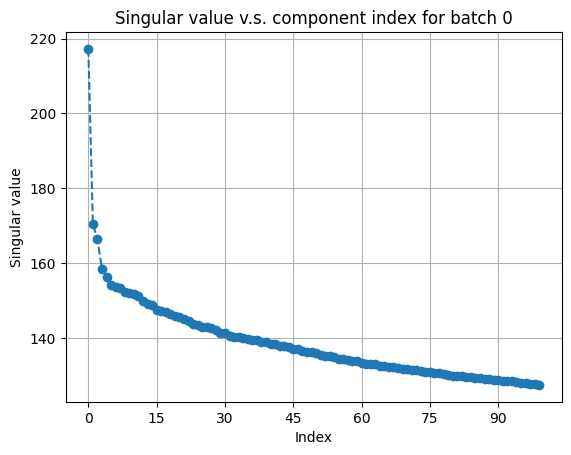

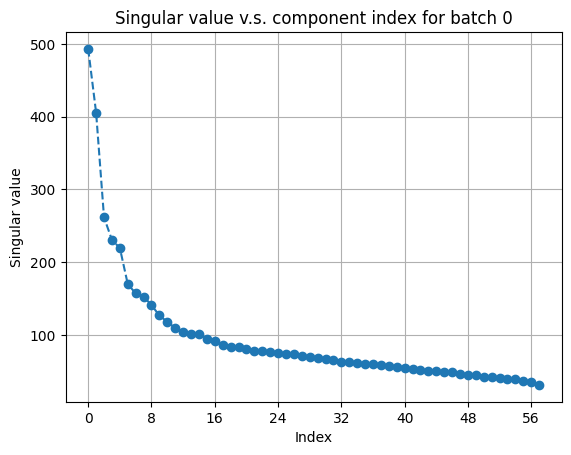

In [51]:

fusor.plot_singular_values(target='active_arr1',  n_components=None)

fusor.plot_singular_values(target='active_arr2',  n_components=None)


In [52]:

fusor.construct_graphs(
    n_neighbors1=15,
    n_neighbors2=15,
    svd_components1=50,
    svd_components2=20,
    resolution1=2, 
    resolution2=2,
    resolution_tol=0.1,
    verbose=True)

Aggregating cells in arr1 into metacells of average size 2...
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering into metacells...
Now at batch 0...
Metacell clustering finished!
Constructing neighborhood graphs for cells in arr1...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr1...
Now at batch 0...
Graph clustering finished!
Constructing neighborhood graphs for cells in arr2...
Now at batch 0...
Graph construction finished!
Clustering the graphs for cells in arr2...
Now at batch 0...
Graph clustering finished!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Singular value v.s. component index for batch 0'}, xlabel='Index', ylabel='Singular value'>)

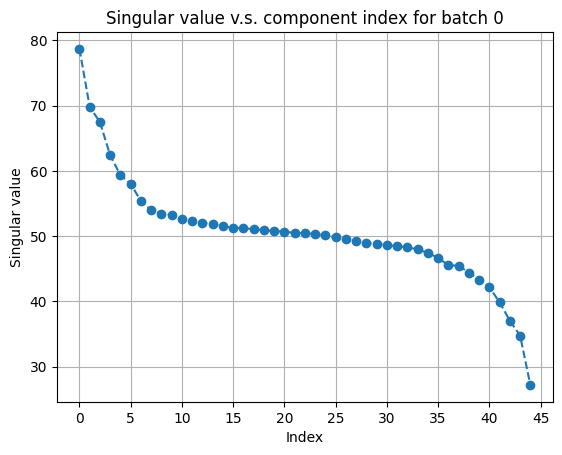

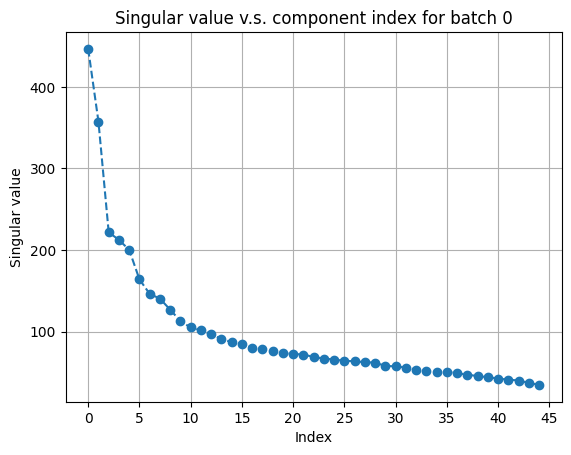

In [53]:
fusor.plot_singular_values(target='shared_arr1',  n_components=None)

fusor.plot_singular_values(target='shared_arr2',  n_components=None)

In [54]:
fusor.find_initial_pivots(
    wt1=0.3, 
    wt2=0.3,
    svd_components1=35,
    svd_components2=25,
    verbose=True
)

Now at batch 0<->0...
Done!


(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Canonical correlation v.s. component index for batch 0<->0'}, xlabel='Index', ylabel='Canonical correlation'>)

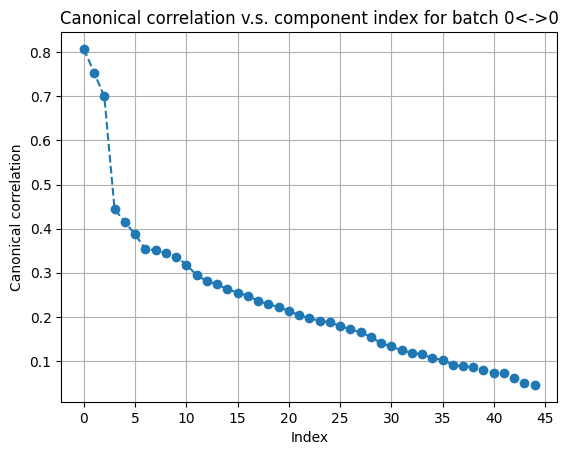

In [55]:
fusor.plot_canonical_correlations(
    svd_components1=50,
    svd_components2=None,
    cca_components=45
)

In [56]:
fusor.refine_pivots(
    wt1=0.3,
    wt2=0.3,
    svd_components1=40,
    svd_components2=None,
    cca_components=30,
    n_iters=1,
    randomized_svd=False,
    svd_runs=1,
    verbose=True
)

Now at batch 0<->0...
Done!


In [57]:
fusor.filter_bad_matches(
    target='pivot',
    filter_prop=0.5,
    verbose=True
)

Begin filtering...
Now at batch 0<->0...
644/1287 pairs of matched cells remain after the filtering.
Fitting CCA on pivots...
Scoring matched pairs...
1248/2574 cells in arr1 are selected as pivots.
644/15512 cells in arr2 are selected as pivots.
Done!


In [58]:
fusor.propagate(
    svd_components1=40,
    svd_components2=None,
    wt1=0.7,
    wt2=0.7,
    verbose=True
)

Now at batch 0<->0...
Done!


In [59]:
fusor.filter_bad_matches(
    target='propagated',
    filter_prop=0.3
)

Begin filtering...
Now at batch 0<->0...
10858/15511 pairs of matched cells remain after the filtering.
Scoring matched pairs...
Done!


In [139]:
full_matching = fusor.get_matching(order=(2, 1), target='full_data')

In [140]:
rna_cca, protein_cca_sub = fusor.get_embedding(
    active_arr1=fusor.active_arr1,
    active_arr2=fusor.active_arr2[full_matching[1],:]
)

In [145]:
# np.random.seed(42)
# subs = 2000
# randix = np.random.choice(protein_cca_sub.shape[0],subs, replace = False)

dim_use = 25 # dimensions of the CCA embedding to be used for UMAP etc

cca_adata = ad.AnnData(
    np.concatenate((rna_cca[:,:dim_use], protein_cca_sub[:,:dim_use]), axis=0),
    dtype=np.float32
)
cca_adata.obs['data_type'] = ['rna'] * rna_cca.shape[0] + ['protein'] * protein_cca_sub.shape[0]
cca_adata.var_names = [f'CCA_{i+1}' for i in range(dim_use)]

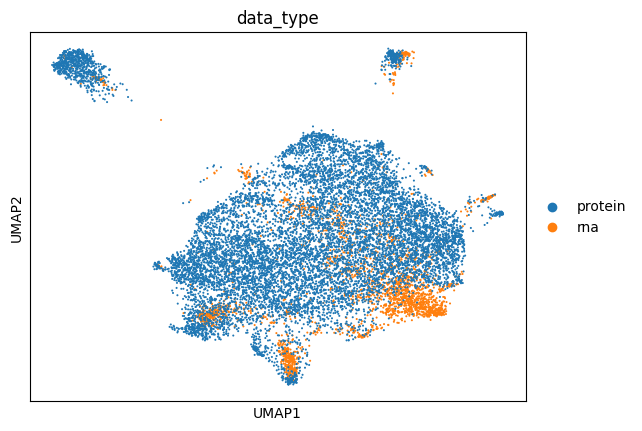

In [146]:
sc.pp.neighbors(cca_adata, n_neighbors=60)
sc.tl.umap(cca_adata, min_dist=0.01, spread=2.5)
sc.pl.umap(cca_adata, color='data_type')

Found 14 clusters


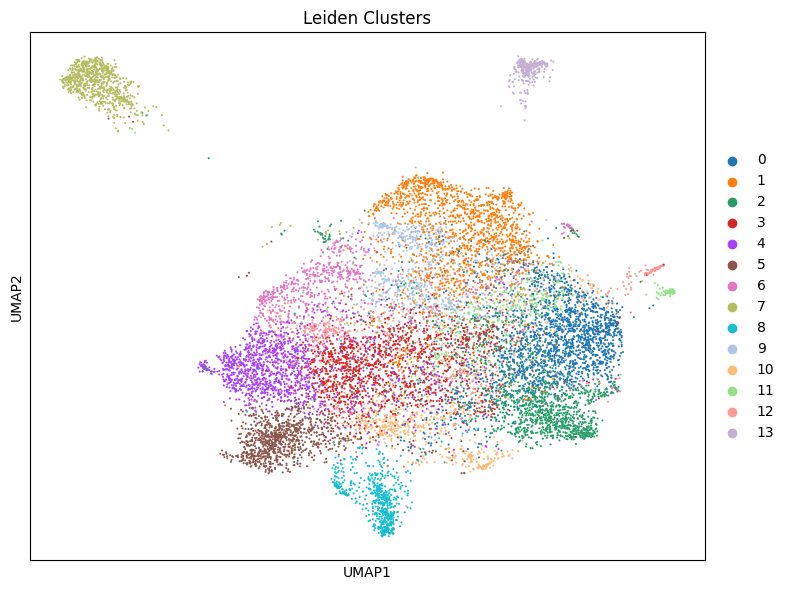

In [147]:
sc.tl.leiden(cca_adata, resolution=1.0)

print(f"Found {len(cca_adata.obs['leiden'].unique())} clusters")

# Visualize clusters
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
sc.pl.umap(cca_adata, color='leiden', ax=ax, show=False,
           title='Leiden Clusters')
plt.tight_layout()
plt.show()


In [107]:
rna_to_prot_matches = {}
for rna_idx, prot_idx, score in zip(full_matching[0], full_matching[1], full_matching[2]):
    if rna_idx not in rna_to_prot_matches:
        rna_to_prot_matches[rna_idx] = []
    rna_to_prot_matches[rna_idx].append((prot_idx, score))

# Create aligned arrays
aligned_rna = []
aligned_prot = []
aligned_rna_indices = []

for rna_idx, matches in rna_to_prot_matches.items():
    prot_indices = [m[0] for m in matches]
    # Average the matched protein cells
    aligned_rna.append(rna_active[rna_idx])
    aligned_prot.append(protein_active[prot_indices].mean(axis=0))
    aligned_rna_indices.append(rna_idx)

aligned_rna = np.array(aligned_rna)
aligned_prot = np.array(aligned_prot)
aligned_rna_indices = np.array(aligned_rna_indices)

print(f"Aligned arrays:")
print(f"  RNA: {aligned_rna.shape}")
print(f"  Protein: {aligned_prot.shape}")
print(f"  Unique RNA cells with matches: {len(aligned_rna_indices)}")

Aligned arrays:
  RNA: (932, 5012)
  Protein: (932, 59)
  Unique RNA cells with matches: 932


In [ ]:
# Find T-cells using CD3e marker
# Get CD3e column index
cd3e_idx = list(protein_adata.var_names).index('CD3e')
cd3e_values = protein_adata.X[:, cd3e_idx]

# Define T-cells as CD3e+ (z-score > 0.5)
tcell_threshold = 0.5
tcell_mask = cd3e_values > tcell_threshold
print(f"T-cells identified: {tcell_mask.sum()} / {len(tcell_mask)} ({100*tcell_mask.mean():.1f}%)")

In [149]:
# Step 1: Identify T-cells in the integrated CCA data
# The cca_adata has RNA cells first, then protein cells
# We'll use CD3E expression to identify T-cells

n_rna = rna_cca.shape[0]
n_prot = protein_cca_sub.shape[0]

print(f"CCA adata structure:")
print(f"  Total cells: {cca_adata.n_obs}")
print(f"  RNA cells: {n_rna}")
print(f"  Protein cells: {n_prot}")

# Get CD3E expression from RNA data (rna_adata has the processed data)
cd3e_rna_idx = list(rna_adata.var_names).index('CD3E')
cd3e_rna_expr = rna_adata.X[:, cd3e_rna_idx]

# Get CD3e expression from protein data
cd3e_prot_idx = list(protein_adata.var_names).index('CD3e')
cd3e_prot_expr = protein_adata.X[:, cd3e_prot_idx]

print(f"\nCD3E/CD3e marker indices:")
print(f"  RNA CD3E index: {cd3e_rna_idx}")
print(f"  Protein CD3e index: {cd3e_prot_idx}")

CCA adata structure:
  Total cells: 13766
  RNA cells: 2574
  Protein cells: 11192

CD3E/CD3e marker indices:
  RNA CD3E index: 2888
  Protein CD3e index: 45


In [150]:
# Add CD3E/CD3e expression to cca_adata for visualization
# For RNA cells: use CD3E from rna_adata
# For protein cells: use CD3e from protein_adata (subset to matched cells)

# The protein cells in cca_adata are the matched subset (full_matching[1])
matched_prot_indices = full_matching[1]

# Create CD3 expression array for all cells in cca_adata
cd3_expr = np.zeros(cca_adata.n_obs)
cd3_expr[:n_rna] = cd3e_rna_expr  # RNA cells
cd3_expr[n_rna:] = cd3e_prot_expr[matched_prot_indices]  # Matched protein cells

cca_adata.obs['CD3_expression'] = cd3_expr

# Define T-cells as CD3+ (z-score > 0.5 for scaled data)
tcell_threshold = 0.5
cca_adata.obs['is_tcell'] = cd3_expr > tcell_threshold
cca_adata.obs['cell_type'] = ['T-cell' if x else 'Other' for x in cca_adata.obs['is_tcell']]

print(f"T-cell identification (CD3 z-score > {tcell_threshold}):")
print(f"  RNA T-cells: {(cd3_expr[:n_rna] > tcell_threshold).sum()} / {n_rna}")
print(f"  Protein T-cells: {(cd3_expr[n_rna:] > tcell_threshold).sum()} / {n_prot}")
print(f"  Total T-cells: {cca_adata.obs['is_tcell'].sum()} / {cca_adata.n_obs}")

T-cell identification (CD3 z-score > 0.5):
  RNA T-cells: 92 / 2574
  Protein T-cells: 2252 / 11192
  Total T-cells: 2344 / 13766


In [ ]:
# Step 2: Visualize T-cells on UMAP and create dotplot of leiden clusters
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# UMAP colored by CD3 expression
sc.pl.umap(cca_adata, color='CD3_expression', ax=axes[0], show=False,
           title='CD3 Expression (Integrated)', cmap='Reds', vmin=-1, vmax=3)

# UMAP colored by T-cell status
sc.pl.umap(cca_adata, color='cell_type', ax=axes[1], show=False,
           title='T-cells vs Other (Integrated)', 
           palette={'T-cell': 'red', 'Other': 'lightgray'})

# UMAP colored by leiden clusters
sc.pl.umap(cca_adata, color='leiden', ax=axes[2], show=False,
           title='Leiden Clusters')

plt.tight_layout()
plt.show()

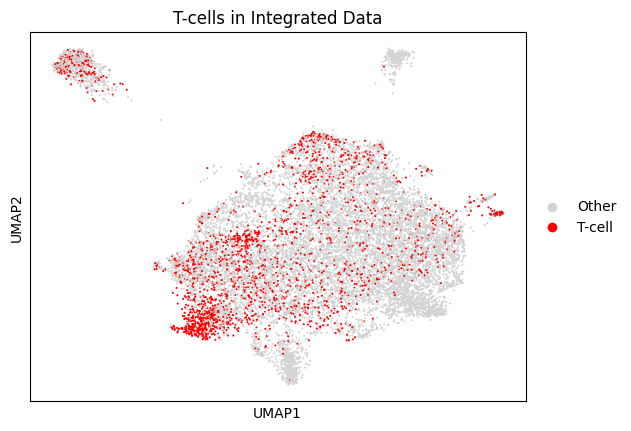

In [151]:
# Simple UMAP of T-cells
sc.pl.umap(cca_adata, color='cell_type', 
           title='T-cells in Integrated Data',
           palette={'T-cell': 'red', 'Other': 'lightgray'})